In [2]:
from torchvision.models import ConvNeXt_Tiny_Weights, convnext_tiny
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Subset
from collections import Counter

data_dir = "food11"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

batch_size = 32
num_epochs = 50
learning_rate_classifier = 1e-3
learning_rate_features = 1e-5

patience = 7  # Больше терпения при fine-tuning
best_acc = 0.0
patience_counter = 0

device = ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Устройство: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_train_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
full_train_clean = datasets.ImageFolder(train_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Split на train/val (80/20)
train_size = int(0.8 * len(full_train_augmented))
val_size = len(full_train_augmented) - train_size

indices = list(range(len(full_train_augmented)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(full_train_augmented, train_indices)
val_dataset = Subset(full_train_clean, val_indices)

num_classes = len(full_train_augmented.classes)
class_names = full_train_augmented.classes
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Классы ({num_classes}): {class_names}")

train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)
print("Распределение классов в train:", class_counts)

# Вычисляем веса для каждого класса
class_weights = [len(train_labels) / (num_classes * class_counts[i]) for i in range(num_classes)]
sample_weights = [class_weights[label] for label in train_labels]

# WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)

for name, param in model.named_parameters():
    if "stages.2" in name or "stages.3" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)

print("Обучаемые параметры (ConvNeXt V2):")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  [Train] {name}")

optimizer = optim.AdamW([  # AdamW — лучше для V2
    {'params': [p for n, p in model.named_parameters() if "stages.2" in n or "stages.3" in n], 'lr': 3e-6},
    {'params': model.classifier.parameters(), 'lr': 3e-4}
], weight_decay=1e-4)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=torch.tensor(class_weights).to(device))
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=2)

writer = SummaryWriter(log_dir="runs/food11_ConvNeXt_V2")

def plot_confusion_matrix(cm, class_names, epoch):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - Epoch {epoch+1}')
    return fig

def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels, cm

start_time = time.time()
print("\nОбучение (fine-tuning + label smoothing + weighted sampling)")

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, ncols=100)

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({'loss': f'{loss.item():.3f}'})

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Валидация
    val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels, val_cm = evaluate_model(model, val_loader, criterion, device)

    # Логи
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)
    writer.add_scalar("Precision/Validation", val_prec, epoch)
    writer.add_scalar("Recall/Validation", val_rec, epoch)
    writer.add_scalar("F1/Validation", val_f1, epoch)
    writer.add_scalar("Learning_Rate_Classifier", optimizer.param_groups[1]['lr'], epoch)
    writer.add_scalar("Learning_Rate_Features", optimizer.param_groups[0]['lr'], epoch)

    if (epoch + 1) % 5 == 0:
        cm_fig = plot_confusion_matrix(val_cm, class_names, epoch)
        writer.add_figure("Confusion_Matrix/Validation", cm_fig, epoch)
        plt.close(cm_fig)

    scheduler.step(val_acc)

    epoch_time = time.time() - epoch_start
    elapsed = time.time() - start_time
    est_remaining = (elapsed / (epoch + 1)) * (num_epochs - (epoch + 1))

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train: L={avg_train_loss:.3f} A={train_acc:.1f}% | "
          f"Val: L={val_loss:.3f} A={val_acc:.1f}% | "
          f"LR_c={optimizer.param_groups[1]['lr']:.2e} LR_f={optimizer.param_groups[0]['lr']:.2e} | "
          f"Time: {epoch_time:.0f}s | ETA: {est_remaining/60:.1f}min")

    # Early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_names': class_names
        }, "ConvNeXt_V2_food11.pth")
        print(f"Лучшая модель сохранена! Val Acc: {best_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"Нет улучшения {patience_counter}/{patience} эпох")
        if patience_counter >= patience:
            print(f"\nОстановка на эпохе {epoch+1}")
            print(f"Лучший результат: {best_acc:.2f}%")
            break


print("Финальная оценка на Test Set...")
checkpoint = torch.load("ConvNeXt_V2_food11.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels, test_cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Accuracy: {test_acc:.2f}% | Precision: {test_prec:.3f} | Recall: {test_rec:.3f} | F1: {test_f1:.3f}")

# Сохраняем матрицу
cm_fig = plot_confusion_matrix(test_cm, class_names, -1)
cm_fig.savefig("confusion_matrix_ConvNeXt_V2.png")
plt.close(cm_fig)
print("Confusion matrix сохранена: confusion_matrix_ConvNeXt_V2.png")

total_time = time.time() - start_time
print(f"Общее время: {total_time/60:.1f} минут")
print(f"Лучшая Val Accuracy: {best_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Модель сохранена: ConvNeXt_V2_food11.pth")

writer.close()

Устройство: mps
Train: 7920 | Val: 1980 | Test: 1100
Классы (11): ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']
Распределение классов в train: Counter({2: 735, 6: 729, 5: 728, 0: 727, 10: 721, 9: 720, 4: 717, 8: 716, 1: 712, 7: 708, 3: 707})
Обучаемые параметры (ConvNeXt V2):
  [Train] classifier.0.weight
  [Train] classifier.0.bias
  [Train] classifier.2.weight
  [Train] classifier.2.bias

Обучение (fine-tuning + label smoothing + weighted sampling)


Epoch 01/50 | Train: L=1.479 A=67.9% | Val: L=0.992 A=83.4% | LR_c=8.59e-05 LR_f=8.59e-07 | Time: 227s | ETA: 185.3min
Лучшая модель сохранена! Val Acc: 83.43%


Epoch 02/50 | Train: L=1.096 A=79.1% | Val: L=0.958 A=84.1% | LR_c=8.13e-05 LR_f=8.13e-07 | Time: 235s | ETA: 184.8min
Лучшая модель сохранена! Val Acc: 84.09%


Epoch 03/50 | Train: L=1.040 A=81.3% | Val: L=0.933 A=85.2% | LR_c=7.40e-05 LR_f=7.40e-07 | Time: 237s | ETA: 182.7min
Лучшая модель сохранена! Val Acc: 85.15%


Epoch 04/50 | Train: L=1.026 A=81.2% | Val: L=0.917 A=85.6% | LR_c=7.09e-05 LR_f=7.09e-07 | Time: 242s | ETA: 180.5min
Лучшая модель сохранена! Val Acc: 85.61%


Epoch 05/50 | Train: L=1.020 A=81.4% | Val: L=0.910 A=85.8% | LR_c=6.99e-05 LR_f=6.99e-07 | Time: 258s | ETA: 180.0min
Лучшая модель сохранена! Val Acc: 85.76%


Epoch 06/50 | Train: L=0.993 A=82.7% | Val: L=0.902 A=85.8% | LR_c=6.96e-05 LR_f=6.96e-07 | Time: 257s | ETA: 178.1min
Лучшая модель сохранена! Val Acc: 85.81%


Epoch 07/50 | Train: L=0.980 A=83.3% | Val: L=0.893 A=86.0% | LR_c=6.86e-05 LR_f=6.86e-07 | Time: 253s | ETA: 175.2min
Лучшая модель сохранена! Val Acc: 85.96%


Epoch 08/50 | Train: L=0.978 A=83.3% | Val: L=0.889 A=86.3% | LR_c=6.63e-05 LR_f=6.63e-07 | Time: 251s | ETA: 171.7min
Лучшая модель сохранена! Val Acc: 86.31%


Epoch 09/50 | Train: L=0.964 A=83.8% | Val: L=0.883 A=86.4% | LR_c=6.56e-05 LR_f=6.56e-07 | Time: 241s | ETA: 167.3min
Лучшая модель сохранена! Val Acc: 86.41%


Epoch 10/50 | Train: L=0.958 A=84.2% | Val: L=0.877 A=87.1% | LR_c=6.11e-05 LR_f=6.11e-07 | Time: 254s | ETA: 163.8min
Лучшая модель сохранена! Val Acc: 87.12%


Epoch 11/50 | Train: L=0.957 A=84.3% | Val: L=0.874 A=86.8% | LR_c=6.33e-05 LR_f=6.33e-07 | Time: 255s | ETA: 160.3min
Нет улучшения 1/7 эпох


Epoch 12/50 | Train: L=0.958 A=84.2% | Val: L=0.870 A=87.1% | LR_c=6.14e-05 LR_f=6.14e-07 | Time: 243s | ETA: 156.0min
Нет улучшения 2/7 эпох


Epoch 13/50 | Train: L=0.942 A=84.9% | Val: L=0.869 A=87.0% | LR_c=6.20e-05 LR_f=6.20e-07 | Time: 241s | ETA: 151.6min
Нет улучшения 3/7 эпох


Epoch 14/50 | Train: L=0.945 A=84.3% | Val: L=0.867 A=87.0% | LR_c=6.17e-05 LR_f=6.17e-07 | Time: 242s | ETA: 147.4min
Нет улучшения 4/7 эпох


Epoch 15/50 | Train: L=0.944 A=84.5% | Val: L=0.865 A=87.0% | LR_c=6.17e-05 LR_f=6.17e-07 | Time: 242s | ETA: 143.1min
Нет улучшения 5/7 эпох


Epoch 16/50 | Train: L=0.940 A=84.8% | Val: L=0.861 A=87.1% | LR_c=6.11e-05 LR_f=6.11e-07 | Time: 240s | ETA: 138.9min
Нет улучшения 6/7 эпох


Epoch 17/50 | Train: L=0.927 A=85.3% | Val: L=0.859 A=87.2% | LR_c=6.04e-05 LR_f=6.04e-07 | Time: 239s | ETA: 134.6min
Лучшая модель сохранена! Val Acc: 87.22%


Epoch 18/50 | Train: L=0.925 A=85.6% | Val: L=0.858 A=87.0% | LR_c=6.20e-05 LR_f=6.20e-07 | Time: 239s | ETA: 130.4min
Нет улучшения 1/7 эпох


Epoch 19/50 | Train: L=0.928 A=85.5% | Val: L=0.858 A=87.2% | LR_c=6.07e-05 LR_f=6.07e-07 | Time: 241s | ETA: 126.2min
Нет улучшения 2/7 эпох


Epoch 20/50 | Train: L=0.922 A=85.5% | Val: L=0.853 A=87.2% | LR_c=6.04e-05 LR_f=6.04e-07 | Time: 242s | ETA: 122.1min
Нет улучшения 3/7 эпох


Epoch 21/50 | Train: L=0.911 A=86.3% | Val: L=0.852 A=87.3% | LR_c=6.01e-05 LR_f=6.01e-07 | Time: 241s | ETA: 117.9min
Лучшая модель сохранена! Val Acc: 87.27%


Epoch 22/50 | Train: L=0.926 A=85.6% | Val: L=0.850 A=87.6% | LR_c=5.82e-05 LR_f=5.82e-07 | Time: 240s | ETA: 113.8min
Лучшая модель сохранена! Val Acc: 87.58%


Epoch 23/50 | Train: L=0.909 A=86.1% | Val: L=0.851 A=87.3% | LR_c=5.98e-05 LR_f=5.98e-07 | Time: 241s | ETA: 109.7min
Нет улучшения 1/7 эпох


Epoch 24/50 | Train: L=0.904 A=86.3% | Val: L=0.848 A=87.6% | LR_c=5.79e-05 LR_f=5.79e-07 | Time: 241s | ETA: 105.5min
Лучшая модель сохранена! Val Acc: 87.63%


Epoch 25/50 | Train: L=0.919 A=85.7% | Val: L=0.847 A=87.6% | LR_c=5.79e-05 LR_f=5.79e-07 | Time: 241s | ETA: 101.4min
Нет улучшения 1/7 эпох


Epoch 26/50 | Train: L=0.909 A=85.9% | Val: L=0.847 A=87.7% | LR_c=5.76e-05 LR_f=5.76e-07 | Time: 241s | ETA: 97.3min
Лучшая модель сохранена! Val Acc: 87.68%


Epoch 27/50 | Train: L=0.910 A=86.1% | Val: L=0.846 A=87.9% | LR_c=5.63e-05 LR_f=5.63e-07 | Time: 241s | ETA: 93.3min
Лучшая модель сохранена! Val Acc: 87.88%


Epoch 28/50 | Train: L=0.903 A=86.5% | Val: L=0.844 A=88.0% | LR_c=5.57e-05 LR_f=5.57e-07 | Time: 240s | ETA: 89.2min
Лучшая модель сохранена! Val Acc: 87.98%


Epoch 29/50 | Train: L=0.894 A=87.1% | Val: L=0.844 A=87.9% | LR_c=5.60e-05 LR_f=5.60e-07 | Time: 241s | ETA: 85.1min
Нет улучшения 1/7 эпох


Epoch 30/50 | Train: L=0.901 A=86.9% | Val: L=0.842 A=87.9% | LR_c=5.63e-05 LR_f=5.63e-07 | Time: 241s | ETA: 81.0min
Нет улучшения 2/7 эпох


Epoch 31/50 | Train: L=0.908 A=86.2% | Val: L=0.841 A=88.1% | LR_c=5.51e-05 LR_f=5.51e-07 | Time: 243s | ETA: 77.0min
Лучшая модель сохранена! Val Acc: 88.08%


Epoch 32/50 | Train: L=0.894 A=86.7% | Val: L=0.840 A=88.4% | LR_c=5.33e-05 LR_f=5.33e-07 | Time: 241s | ETA: 72.9min
Лучшая модель сохранена! Val Acc: 88.38%


Epoch 33/50 | Train: L=0.905 A=86.1% | Val: L=0.839 A=88.3% | LR_c=5.39e-05 LR_f=5.39e-07 | Time: 241s | ETA: 68.8min
Нет улучшения 1/7 эпох


Epoch 34/50 | Train: L=0.897 A=86.9% | Val: L=0.838 A=88.2% | LR_c=5.42e-05 LR_f=5.42e-07 | Time: 242s | ETA: 64.8min
Нет улучшения 2/7 эпох


Epoch 35/50 | Train: L=0.899 A=86.5% | Val: L=0.837 A=88.1% | LR_c=5.51e-05 LR_f=5.51e-07 | Time: 241s | ETA: 60.7min
Нет улучшения 3/7 эпох


Epoch 36/50 | Train: L=0.896 A=86.8% | Val: L=0.838 A=88.2% | LR_c=5.42e-05 LR_f=5.42e-07 | Time: 241s | ETA: 56.7min
Нет улучшения 4/7 эпох


Epoch 37/50 | Train: L=0.893 A=86.8% | Val: L=0.839 A=88.4% | LR_c=5.33e-05 LR_f=5.33e-07 | Time: 241s | ETA: 52.6min
Нет улучшения 5/7 эпох


Epoch 38/50 | Train: L=0.895 A=86.9% | Val: L=0.838 A=88.2% | LR_c=5.45e-05 LR_f=5.45e-07 | Time: 240s | ETA: 48.5min
Нет улучшения 6/7 эпох


Epoch 39/50 | Train: L=0.892 A=86.6% | Val: L=0.836 A=88.3% | LR_c=5.39e-05 LR_f=5.39e-07 | Time: 242s | ETA: 44.5min
Нет улучшения 7/7 эпох

Остановка на эпохе 39
Лучший результат: 88.38%
Финальная оценка на Test Set...
Test Loss: 0.849 | Accuracy: 88.55% | Precision: 0.890 | Recall: 0.885 | F1: 0.887
Confusion matrix сохранена: confusion_matrix_ConvNeXt_V2.png
Общее время: 158.1 минут
Лучшая Val Accuracy: 88.38%
Test Accuracy: 88.55%
Модель сохранена: ConvNeXt_V2_food11.pth


In [3]:
def tta_predict(model, loader, device, num_augs=5):
    model.eval()
    all_preds = []

    transforms_list = [
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.RandomAffine(degrees=5, scale=(0.95, 1.05))
    ]

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            probs = torch.zeros(images.size(0), num_classes, device=device)

            # Оригинал
            probs += torch.softmax(model(images), dim=1)

            # Аугментации
            for t in transforms_list:
                aug_imgs = t(images)
                probs += torch.softmax(model(aug_imgs), dim=1)

            probs /= (1 + len(transforms_list))
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds

In [4]:
# Замени финальную оценку:
test_preds = tta_predict(model, test_loader, device, num_augs=5)
test_labels = [label for _, label in test_loader.dataset]
test_acc = 100.0 * np.mean(np.array(test_preds) == np.array(test_labels))
print(f"TTA Test Accuracy: {test_acc:.2f}%")

TTA Test Accuracy: 89.18%


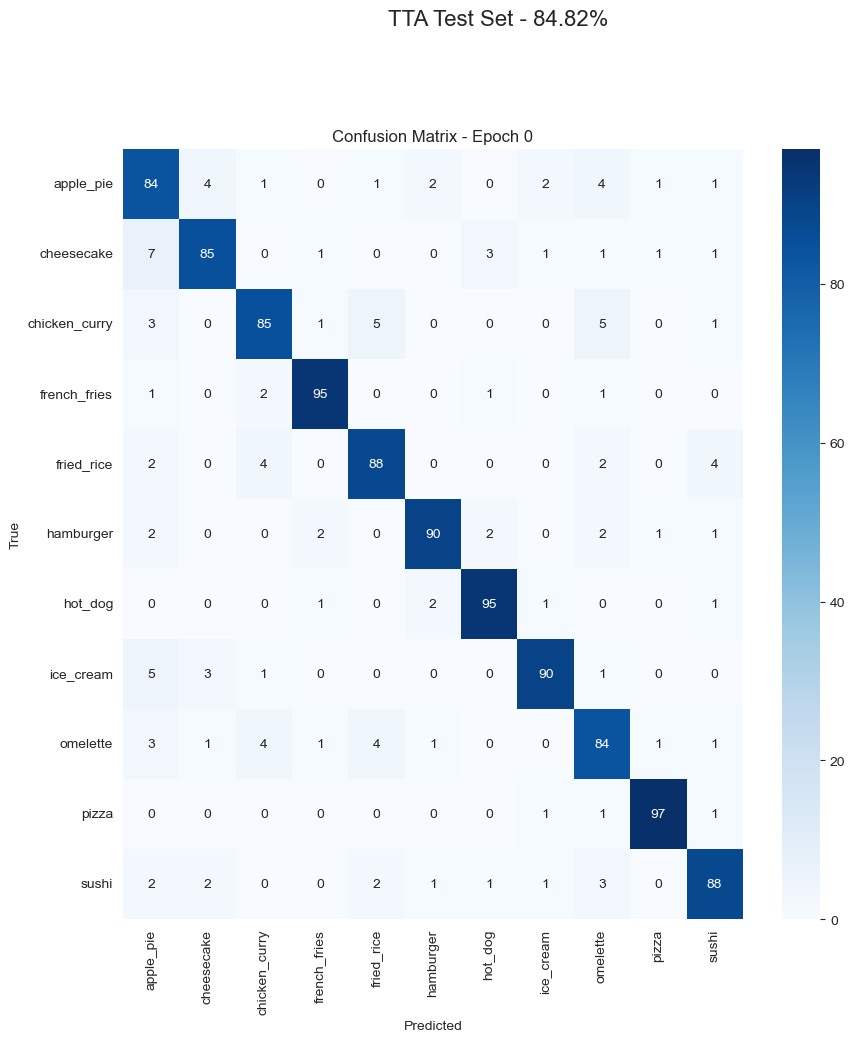

In [6]:
cm_tta = confusion_matrix(test_labels, test_preds)
cm_fig = plot_confusion_matrix(cm_tta, class_names, epoch=-1)
cm_fig.suptitle("TTA Test Set - 89.18%", fontsize=16, y=1.02)
cm_fig.savefig("FINAL_confusion_matrix_TTA_89.18%.png", dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
from torchvision.models import ConvNeXt_Tiny_Weights, convnext_tiny
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Subset
from collections import Counter
import timm
import types

data_dir = "food11"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

batch_size = 32
num_epochs = 50  # Увеличили — будем дообучать глубже
learning_rate_classifier = 1e-3
learning_rate_features = 1e-5  # Меньше для размороженных слоёв

patience = 7  # Больше терпения при fine-tuning
best_acc = 0.0
patience_counter = 0

# device = ("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"
print(f"Устройство: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_train_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
full_train_clean = datasets.ImageFolder(train_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Split на train/val (80/20)
train_size = int(0.8 * len(full_train_augmented))
val_size = len(full_train_augmented) - train_size

indices = list(range(len(full_train_augmented)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(full_train_augmented, train_indices)
val_dataset = Subset(full_train_clean, val_indices)

num_classes = len(full_train_augmented.classes)
class_names = full_train_augmented.classes
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Классы ({num_classes}): {class_names}")

train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)
print("Распределение классов в train:", class_counts)

# Вычисляем веса для каждого класса
class_weights = [len(train_labels) / (num_classes * class_counts[i]) for i in range(num_classes)]
sample_weights = [class_weights[label] for label in train_labels]

# WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Создаём модель
raw_model = timm.create_model('davit_tiny.msft_in1k', pretrained=True, num_classes=num_classes)

# Замораживаем слои
for name, param in raw_model.named_parameters():
    if "stages.2" in name or "stages.3" in name or "head" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Оборачиваем
model = raw_model.to(device)

print("Обучаемые параметры (DaViT Tiny):")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  [Train] {name}")

optimizer = optim.AdamW([
    {'params': [p for n, p in raw_model.named_parameters() if "stages.2" in n or "stages.3" in n], 'lr': 1e-5},
    {'params': raw_model.head.parameters(), 'lr': 3e-4}
], weight_decay=0.05)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=torch.tensor(class_weights).to(device))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

writer = SummaryWriter(log_dir="runs/food11_DaViT_Tiny")

def plot_confusion_matrix(cm, class_names, epoch):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - Epoch {epoch+1}')
    return fig

def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels, cm

start_time = time.time()
print("\nОбучение (fine-tuning + label smoothing + weighted sampling)")

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, ncols=100)

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix({'loss': f'{loss.item():.3f}'})

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Валидация
    val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels, val_cm = evaluate_model(model, val_loader, criterion, device)

    # Логи
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc, epoch)
    writer.add_scalar("Precision/Validation", val_prec, epoch)
    writer.add_scalar("Recall/Validation", val_rec, epoch)
    writer.add_scalar("F1/Validation", val_f1, epoch)
    writer.add_scalar("Learning_Rate_Classifier", optimizer.param_groups[1]['lr'], epoch)
    writer.add_scalar("Learning_Rate_Features", optimizer.param_groups[0]['lr'], epoch)

    if (epoch + 1) % 5 == 0:
        cm_fig = plot_confusion_matrix(val_cm, class_names, epoch)
        writer.add_figure("Confusion_Matrix/Validation", cm_fig, epoch)
        plt.close(cm_fig)

    scheduler.step(val_acc)

    epoch_time = time.time() - epoch_start
    elapsed = time.time() - start_time
    est_remaining = (elapsed / (epoch + 1)) * (num_epochs - (epoch + 1))

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"Train: L={avg_train_loss:.3f} A={train_acc:.1f}% | "
          f"Val: L={val_loss:.3f} A={val_acc:.1f}% | "
          f"LR_c={optimizer.param_groups[1]['lr']:.2e} LR_f={optimizer.param_groups[0]['lr']:.2e} | "
          f"Time: {epoch_time:.0f}s | ETA: {est_remaining/60:.1f}min")

    # Early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_names': class_names
        }, "DaViT_Tiny_food11.pth")
        print(f"Лучшая модель сохранена! Val Acc: {best_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"Нет улучшения {patience_counter}/{patience} эпох")
        if patience_counter >= patience:
            print(f"\nОстановка на эпохе {epoch+1}")
            print(f"Лучший результат: {best_acc:.2f}%")
            break


print("Финальная оценка на Test Set...")
checkpoint = torch.load("DaViT_Tiny_food11.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels, test_cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Accuracy: {test_acc:.2f}% | Precision: {test_prec:.3f} | Recall: {test_rec:.3f} | F1: {test_f1:.3f}")

# Сохраняем матрицу
cm_fig = plot_confusion_matrix(test_cm, class_names, -1)
cm_fig.savefig("confusion_matrix_DaViT_Tiny.png")
plt.close(cm_fig)
print("Confusion matrix сохранена: confusion_matrix_DaViT_Tiny.png")

total_time = time.time() - start_time
print(f"Общее время: {total_time/60:.1f} минут")
print(f"Лучшая Val Accuracy: {best_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Модель сохранена: DaViT_Tiny_food11.pth")

writer.close()

Устройство: cpu
Train: 7920 | Val: 1980 | Test: 1100
Классы (11): ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']
Распределение классов в train: Counter({2: 735, 6: 729, 5: 728, 0: 727, 10: 721, 9: 720, 4: 717, 8: 716, 1: 712, 7: 708, 3: 707})
Обучаемые параметры (DaViT Tiny):
  [Train] stages.2.downsample.norm.weight
  [Train] stages.2.downsample.norm.bias
  [Train] stages.2.downsample.conv.weight
  [Train] stages.2.downsample.conv.bias
  [Train] stages.2.blocks.0.0.cpe1.proj.weight
  [Train] stages.2.blocks.0.0.cpe1.proj.bias
  [Train] stages.2.blocks.0.0.norm1.weight
  [Train] stages.2.blocks.0.0.norm1.bias
  [Train] stages.2.blocks.0.0.attn.qkv.weight
  [Train] stages.2.blocks.0.0.attn.qkv.bias
  [Train] stages.2.blocks.0.0.attn.proj.weight
  [Train] stages.2.blocks.0.0.attn.proj.bias
  [Train] stages.2.blocks.0.0.cpe2.proj.weight
  [Train] stages.2.blocks.0.0.cpe2.proj.bias
  [Train] stag

/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 01/50 | Train: L=1.274 A=75.8% | Val: L=0.876 A=87.5% | LR_c=2.80e-04 LR_f=9.39e-06 | Time: 1377s | ETA: 1124.2min
Лучшая модель сохранена! Val Acc: 87.47%


/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 02/50 | Train: L=0.838 A=87.6% | Val: L=0.809 A=89.5% | LR_c=2.99e-04 LR_f=9.98e-06 | Time: 1370s | ETA: 1099.1min
Лучшая модель сохранена! Val Acc: 89.55%


/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 03/50 | Train: L=0.767 A=91.2% | Val: L=0.773 A=91.3% | LR_c=2.94e-04 LR_f=9.83e-06 | Time: 1322s | ETA: 1062.8min
Лучшая модель сохранена! Val Acc: 91.31%


/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 04/50 | Train: L=0.722 A=93.1% | Val: L=0.762 A=91.1% | LR_c=2.96e-04 LR_f=9.88e-06 | Time: 1356s | ETA: 1040.3min
Нет улучшения 1/7 эпох


/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 05/50 | Train: L=0.696 A=94.3% | Val: L=0.750 A=91.6% | LR_c=2.92e-04 LR_f=9.74e-06 | Time: 1330s | ETA: 1013.6min
Лучшая модель сохранена! Val Acc: 91.62%


/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 06/50 | Train: L=0.680 A=94.7% | Val: L=0.735 A=92.4% | LR_c=2.81e-04 LR_f=9.43e-06 | Time: 1394s | ETA: 996.4min
Лучшая модель сохранена! Val Acc: 92.42%


/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 07/50 | Train: L=0.667 A=95.2% | Val: L=0.730 A=92.5% | LR_c=2.80e-04 LR_f=9.41e-06 | Time: 1555s | ETA: 994.0min
Лучшая модель сохранена! Val Acc: 92.47%


/opt/miniconda3/envs/torch_ml/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 08/50 | Train: L=0.648 A=96.4% | Val: L=0.728 A=92.2% | LR_c=2.84e-04 LR_f=9.52e-06 | Time: 1574s | ETA: 987.3min
Нет улучшения 1/7 эпох


Epoch 9/50 [Train]:  47%|█████████████▌               | 116/248 [12:19<17:25,  7.92s/it, loss=0.617]

In [ ]:
test_preds = tta_predict(model, test_loader, device, num_augs=5)
test_labels = [label for _, label in test_loader.dataset]
test_acc = 100.0 * np.mean(np.array(test_preds) == np.array(test_labels))
print(f"TTA Test Accuracy: {test_acc:.2f}%")

In [ ]:
cm_tta = confusion_matrix(test_labels, test_preds)
cm_fig = plot_confusion_matrix(cm_tta, class_names, epoch=-1)
cm_fig.suptitle(f"TTA Test Set - {test_acc}%", fontsize=16, y=1.02)
cm_fig.savefig("FINAL_confusion_matrix_TTA_XXX%.png", dpi=200, bbox_inches='tight')
plt.show()